In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

from sklearn.model_selection import train_test_split

import help
from MyDataSet import MyDataset

深度学习中针对图像分类，基本上都离不开卷积(英语：Convolution)，也是卷进神经网络CNN首字母（英语：Convolution Neural Networks）。所谓2D卷积，用大白话讲，理解为一幅平面的图片上，通过卷积核（n\*m的一个二维数组）在图片上滑动（卷积处理），反复调整卷积核的参数（训练过程），从而获得一组**卷积核参数**用于提取图片特征。

<center><img id="img1" width="300px" height="300px" src="image/2D卷积.webp">2D卷积</img></center>

reshape输入的测试样本，当做300个(79,95,79)的图片处理，仿照RGB处理模式

In [2]:
features = help.features.reshape(300,79,95,79)
features.shape

(300, 79, 95, 79)

In [3]:
X_train, X_val, y_train, y_val = train_test_split(features,help.labels['label'].values,test_size = 0.2,random_state = 42)

train_datasets = MyDataset(datas=X_train,labels=y_train,shape=2,input_D=help.input_D,input_H=help.input_H,input_W=help.input_W,phase='train')
val_datasets = MyDataset(datas=X_val,labels=y_val,shape=2,input_D=help.input_D,input_H=help.input_H,input_W=help.input_W,phase='train')

train_loader = torch.utils.data.DataLoader(dataset=train_datasets, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_datasets, batch_size=8, shuffle=False)

In [4]:
model_resnet50 = models.resnet50(pretrained=True)
fc_features = model_resnet50.fc.in_features

In [5]:
with torch.no_grad():
    pretrained_conv1 = model_resnet50.conv1.weight.clone()
    # Assign new conv layer with 79 input channels
    model_resnet50.conv1 = torch.nn.Conv2d(features.shape[1], 64, 7, 2, 3, bias=False)
    # Use same initialization as vanilla ResNet (Don't know if good idea)
    torch.nn.init.kaiming_normal_(model_resnet50.conv1.weight, mode='fan_out', nonlinearity='relu')
    # Re-assign pretraiend weights to first 3 channels
    # (assuming alpha channel is last in your input data)
    model_resnet50.conv1.weight[:, :3] = pretrained_conv1
    
for param in model_resnet50.parameters():
    param.requires_grad = False
    
#分类器在resnet50基础上修改，输出output_size为种类3
resnet50_fc = nn.Sequential(nn.Linear(fc_features, help.num_seg_classes))
model_resnet50.fc = resnet50_fc

Epochs: 1/100... Trian Loss:0.793... Trian Accuracy:0.596... Trian F1 Score:0.500... Val Loss:0.417... Val Accuracy:0.800... Val F1 Score:0.562
Epochs: 2/100... Trian Loss:0.433... Trian Accuracy:0.817... Trian F1 Score:0.738... Val Loss:0.337... Val Accuracy:0.833... Val F1 Score:0.737
Epochs: 3/100... Trian Loss:0.327... Trian Accuracy:0.850... Trian F1 Score:0.805... Val Loss:0.340... Val Accuracy:0.800... Val F1 Score:0.567
Epochs: 4/100... Trian Loss:0.323... Trian Accuracy:0.858... Trian F1 Score:0.813... Val Loss:0.286... Val Accuracy:0.867... Val F1 Score:0.790
Epochs: 5/100... Trian Loss:0.267... Trian Accuracy:0.904... Trian F1 Score:0.874... Val Loss:0.282... Val Accuracy:0.867... Val F1 Score:0.783
Epochs: 6/100... Trian Loss:0.245... Trian Accuracy:0.892... Trian F1 Score:0.859... Val Loss:0.278... Val Accuracy:0.883... Val F1 Score:0.814
Epochs: 7/100... Trian Loss:0.260... Trian Accuracy:0.912... Trian F1 Score:0.884... Val Loss:0.263... Val Accuracy:0.850... Val F1 Scor

Epochs: 58/100... Trian Loss:0.175... Trian Accuracy:0.942... Trian F1 Score:0.925... Val Loss:0.285... Val Accuracy:0.883... Val F1 Score:0.814
Epochs: 59/100... Trian Loss:0.184... Trian Accuracy:0.938... Trian F1 Score:0.918... Val Loss:0.274... Val Accuracy:0.867... Val F1 Score:0.783
Epochs: 60/100... Trian Loss:0.203... Trian Accuracy:0.942... Trian F1 Score:0.925... Val Loss:0.272... Val Accuracy:0.883... Val F1 Score:0.806
Epochs: 61/100... Trian Loss:0.187... Trian Accuracy:0.933... Trian F1 Score:0.913... Val Loss:0.282... Val Accuracy:0.900... Val F1 Score:0.838
Epochs: 62/100... Trian Loss:0.196... Trian Accuracy:0.929... Trian F1 Score:0.909... Val Loss:0.292... Val Accuracy:0.883... Val F1 Score:0.814
Epochs: 63/100... Trian Loss:0.176... Trian Accuracy:0.954... Trian F1 Score:0.940... Val Loss:0.285... Val Accuracy:0.883... Val F1 Score:0.814
Epochs: 64/100... Trian Loss:0.149... Trian Accuracy:0.971... Trian F1 Score:0.962... Val Loss:0.264... Val Accuracy:0.883... Val 

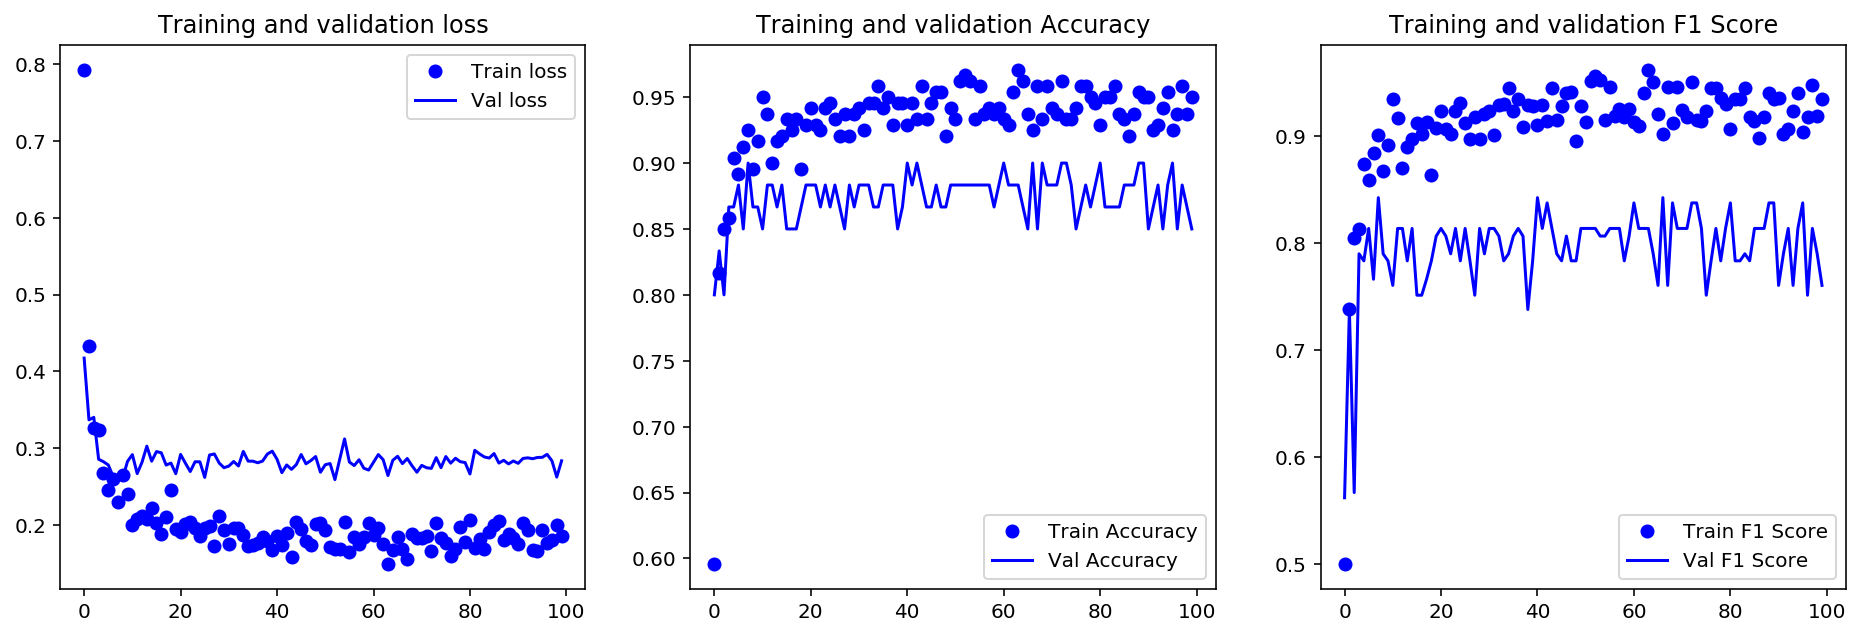

Training time is 19m 35s


In [6]:
epochs = 100
optimizer = optim.Adam(model_resnet50.fc.parameters())
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
help.train_data(model_resnet50,train_loader,val_loader,epochs,optimizer,scheduler,help.criterion,help.resnet50_2d_checkpoint_path,help.device)


In [7]:
test_datasets = MyDataset(datas=help.temp_data.reshape(232,79,95,79),shape=2,input_D=help.input_D,input_H=help.input_H,input_W=help.input_W,phase='test')
test_loader = torch.utils.data.DataLoader(dataset=test_datasets)

In [19]:
import time
import pandas as pd
import numpy as np
def all_predict(test_dataloader,loadmodel,device,result_path):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    start = time.time()
    result_df = pd.DataFrame(columns=['testa_id','label'])
    
    with torch.no_grad():
        loadmodel.to(device)
        loadmodel.eval()
        for ii,image in enumerate(test_dataloader):
            image = image.to(device)
            output = loadmodel(image)
            _,indexs = torch.max(output.data,1)
            #probs,indexs = output.topk(topk)
            #probs = np.squeeze(probs.cpu().detach().numpy()).tolist()
            indexs = np.squeeze(indexs.cpu().detach().numpy()).tolist()
            if ii < 116:
                result_df.loc[result_df.shape[0]] = [('testa_{}'.format(ii)),indexs]
            else:
                result_df.loc[result_df.shape[0]] = [('testb_{}'.format(ii - 116)),indexs]
    
            if ii%20==0:
                print('{} test data have been predicted'.format(ii))
                print('--'*20)
    result_df.to_csv(result_path,index=False)
    end = time.time()
    runing_time = end - start
    print('Test time is {:.0f}m {:.0f}s'.format(runing_time//60,runing_time%60))

In [20]:
loadmodel = help.load_checkpoint(help.resnet50_2d_checkpoint_path,'resnet50_2d',help.device)
help.all_predict(test_loader,loadmodel,help.device,help.result_2d_resnet50)

0 test data have been predicted
----------------------------------------
20 test data have been predicted
----------------------------------------
40 test data have been predicted
----------------------------------------
60 test data have been predicted
----------------------------------------
80 test data have been predicted
----------------------------------------
100 test data have been predicted
----------------------------------------
120 test data have been predicted
----------------------------------------
140 test data have been predicted
----------------------------------------
160 test data have been predicted
----------------------------------------
180 test data have been predicted
----------------------------------------
200 test data have been predicted
----------------------------------------
220 test data have been predicted
----------------------------------------
Test time is 0m 12s
